## Regularized mean (target) encoding for Avazu competition

In [1]:
import numpy as np
import pandas as pd

For this problem I will implement a version of regularized mean encoding using the data on this Kaggle [compettion](https://www.kaggle.com/c/avazu-ctr-prediction).  

**Instructions:**
- Split data (training) into training and validation. Take the last week (7 days) of training set as validation.
- Implement regularized mean encoding for the training set using pandas.
- Implement mean encoding for the validation set

In [3]:
## Split train and validation 
# get sample data first
path = "avazu/"
!head -100000 $path/train > $path/train_sample.csv
!head -100000 $path/test > $path/test_sample.csv
data = pd.read_csv(path + "train_sample.csv")
test = pd.read_csv(path + "test_sample.csv")

In [4]:
def split_based_hour(data):
    """ Split data based on column hour.
    
    Use 20% of the date for validation.
    Inputs:
       data: dataframe from avazu
    Returns:
       train:
       val: 20% of the largest values of column "hour".
    """
    N = int(0.8*len(data))
    data = data.sort_values(by="hour")
    train = data[:N].copy()
    val = data[N:].copy()
    return train.reset_index(), val.reset_index()
train, val = split_based_hour(data)

### Regularized mean encoding without regularization

In [5]:
# Calculate a mapping: {device_type: click_mean}
mean_device_type = train.groupby('device_type').click.mean()
mean_device_type

device_type
0    0.224277
1    0.176116
4    0.069777
5    0.083333
Name: click, dtype: float64

In [6]:
# This is the global click mean
global_mean = train.click.mean()
global_mean

0.17477718471480894

In [7]:
train["device_type_mean_enc"] = train["device_type"].map(mean_device_type)
val["device_type_mean_enc"] = val["device_type"].map(mean_device_type)

In [8]:
train["device_type_mean_enc"].fillna(global_mean, inplace=True)
val["device_type_mean_enc"].fillna(global_mean, inplace=True)

In [9]:
# Print correlation
encoded_feature = val["device_type_mean_enc"].values
print(np.corrcoef(val["click"].values, encoded_feature)[0][1])

0.053038922999821464


To do mean encoding with K-fold regularization I do the following:

* Run a 5-fold split on train data where `mean_device_type` is computed on 4/5 of the data and the encoding is computed on the other 1/5.
* To compute mean encoding on the validation data use the code similar to encoding without regularization. That is compute on all the training data and apply to the validation set.

In [10]:
from sklearn.model_selection import KFold

def reg_target_encoding(train, col = "device_type", splits=5):
    """ Computes regularize mean encoding.
    Inputs:
       train: training dataframe  
    """
    train[col+'_mean_enc'] = np.nan
    kfold = KFold(n_splits=splits)
    for tr, val in kfold.split(train):
        mean_by_col = train.loc[tr].groupby(col).click.mean()
        train.loc[val, col+'_mean_enc'] = train.loc[val][col].map(mean_by_col)

In [11]:
reg_target_encoding(train) 
encoded_feature = train["device_type_mean_enc"].values
corr = np.corrcoef(train["click"].values, encoded_feature)[0][1]

In [12]:
def mean_encoding_test(test, train, col = "device_type"):
    """ Computes target enconding for test data.
    
    This is similar to how we do validation
    """
    mean_by_col = train.groupby(col).click.mean()
    global_mean = train.click.mean()
    test[col+'_mean_enc'] = test[col].map(mean_by_col)
    test[col+'_mean_enc'].fillna(global_mean, inplace=True)

In [13]:
mean_encoding_test(test, train) 
encoded_feature_mean = test["device_type_mean_enc"].values.mean()

## Implement other features and fit a model
* Implement a few more features, include:
   * day of the week and hour
   * mean encoding of some other features (at least two)
   * use plots and `value_counts()` to understand the data

* Fit a random forest (to the whole dataset)
   * Do hyperparameter tunning using your validation set
   * Report test and train log loss

### Load Data

In [14]:
def load_data():
    path = "avazu/"
    data = pd.read_csv(path + "train")
    test = pd.read_csv(path + "test")
    return data, test

In [15]:
types_data = {'id': np.uint32, 'click': np.uint8, 'hour': np.uint32, 'C1': np.uint32, 'banner_pos': np.uint8,
         'site_id': 'category', 'site_domain': 'category', 'site_category': 'category', 'app_id': 'category',
         'app_domain': 'category', 'app_category': 'category', 'device_id': 'category',
         'device_ip': 'category', 'device_model': 'category', 'device_type': np.uint8, 'device_conn_type': np.uint8,
         'C14': np.uint16, 'C15': np.uint16, 'C16': np.uint16, 'C17': np.uint16, 'C18': np.uint16, 'C19': np.uint16,
         'C20': np.uint16, 'C21': np.uint16}

types_test = {'id': np.uint32, 'hour': np.uint32, 'C1': np.uint32, 'banner_pos': np.uint8,
         'site_id': 'category', 'site_domain': 'category', 'site_category': 'category', 'app_id': 'category',
         'app_domain': 'category', 'app_category': 'category', 'device_id': 'category',
         'device_ip': 'category', 'device_model': 'category', 'device_type': np.uint8, 'device_conn_type': np.uint8,
         'C14': np.uint16, 'C15': np.uint16, 'C16': np.uint16, 'C17': np.uint16, 'C18': np.uint16, 'C19': np.uint16,
         'C20': np.uint16, 'C21': np.uint16}

def load_data2(types_data, types_test):
    path = "avazu/"
    data = pd.read_csv(path+"train", usecols=types_data.keys(), dtype=types_data)
    test = pd.read_csv(path+"test", usecols=types_test.keys(), dtype=types_test)
    return data, test

In [16]:
data, test = load_data2(types_data, types_test)

In [17]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 24 columns):
id                  uint32
click               uint8
hour                uint32
C1                  uint32
banner_pos          uint8
site_id             category
site_domain         category
site_category       category
app_id              category
app_domain          category
app_category        category
device_id           category
device_ip           category
device_model        category
device_type         uint8
device_conn_type    uint8
C14                 uint16
C15                 uint16
C16                 uint16
C17                 uint16
C18                 uint16
C19                 uint16
C20                 uint16
C21                 uint16
dtypes: category(9), uint16(8), uint32(3), uint8(4)
memory usage: 2.9 GB


In [18]:
data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,2096162817,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,65535,79
1,871065379,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,34548,79
2,1015674494,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,34548,79
3,3573304040,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,34548,79
4,2926390960,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,65535,157


In [19]:
print(len(data), len(test))

40428967 4577464


### Day of the Week and Hour

In [20]:
# get day of week and hour
def dayofweek_hour(df):
    df['date'] = 2000000000 + df['hour']
    df['date'] = pd.to_datetime(df['date'],format='%Y%m%d%H')
    df['day_of_week'] = df['date'].dt.weekday
    df['hour'] = df['date'].dt.hour


data2 = data.copy()
test2 = test.copy()
dayofweek_hour(data2)
dayofweek_hour(test2)

In [21]:
# drop some columns
data2.drop(['site_id', 'site_domain', 'app_id', 'app_domain', 'device_id', 'device_ip', 
          'device_model', 'date'], 1, inplace=True)
data2.head()

,id,click,hour,C1,banner_pos,site_category,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,day_of_week
0,2096162817,0,0,1005,0,28905ebd,07d7df22,1,2,15706,320,50,1722,0,35,65535,79,1
1,871065379,0,0,1005,0,28905ebd,07d7df22,1,0,15704,320,50,1722,0,35,34548,79,1
2,1015674494,0,0,1005,0,28905ebd,07d7df22,1,0,15704,320,50,1722,0,35,34548,79,1
3,3573304040,0,0,1005,0,28905ebd,07d7df22,1,0,15706,320,50,1722,0,35,34548,79,1
4,2926390960,0,0,1005,1,0569f928,07d7df22,1,0,18993,320,50,2161,0,35,65535,157,1


In [22]:
data2.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_category',
       'app_category', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'day_of_week'],
      dtype='object')

### Train Test Split

In [23]:
def train_val_split(df):
    """ Split data based on column id."""
    df = df.dropna()
    N = int(0.8*len(df))
    df = df.sort_values(by="id")
    train = df[:N].copy()
    val = df[N:].copy()
    return train.reset_index(), val.reset_index()

bigtrain, test = train_val_split(data2)

### Mean Encoding

In [24]:
reg_target_encoding(bigtrain, col="hour", splits=5)
reg_target_encoding(bigtrain, col="banner_pos", splits=5)
reg_target_encoding(bigtrain, col="site_category", splits=5)
reg_target_encoding(bigtrain, col="app_category", splits=5)
reg_target_encoding(bigtrain, col="device_type", splits=5)
reg_target_encoding(bigtrain, col="day_of_week", splits=5)

In [25]:
mean_encoding_test(test, bigtrain, col="hour") 
mean_encoding_test(test, bigtrain, col="banner_pos") 
mean_encoding_test(test, bigtrain, col="site_category") 
mean_encoding_test(test, bigtrain, col="app_category") 
mean_encoding_test(test, bigtrain, col="device_type") 
mean_encoding_test(test, bigtrain, col="day_of_week")

In [26]:
bigtrain.drop(['site_category', 'app_category'], 1, inplace=True)
test.drop(['site_category', 'app_category', 'id'], 1, inplace=True)
train, val = train_val_split(bigtrain)
train.drop('id', 1, inplace=True)
val.drop('id', 1, inplace=True)
train.drop(['level_0', 'index'], 1, inplace=True)
val.drop(['level_0', 'index'], 1, inplace=True)
test.drop('index', 1, inplace=True)

### Plots

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
train.banner_pos.value_counts()

0    18627418
1     7201061
7       27849
2        8314
4        4885
5        3693
3        1312
Name: banner_pos, dtype: int64

In [29]:
train.C1.value_counts()

1005    23768476
1002     1421802
1010      578914
1012       72800
1007       22735
1001        6105
1008        3700
Name: C1, dtype: int64

In [30]:
train.device_type.value_counts()

1    23873798
0     1421802
4      496520
5       82394
2          18
Name: device_type, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

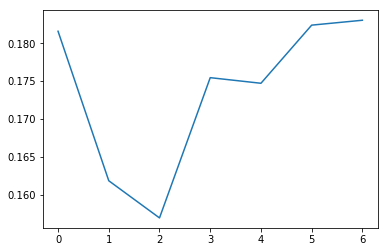

In [31]:
dow = pd.DataFrame({'mean_click_by_dow' : data2.click.groupby(data2['day_of_week']).mean()}).reset_index()
plt.plot(dow.day_of_week, dow.mean_click_by_dow)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

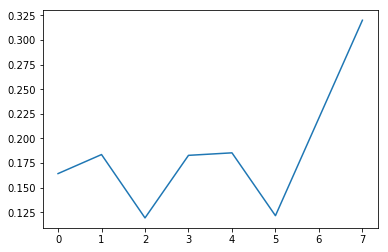

In [32]:
pos = pd.DataFrame({'mean_click_by_banner_pos' : data2.click.groupby(data2['banner_pos']).mean()}).reset_index()
plt.plot(pos.banner_pos, pos.mean_click_by_banner_pos)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

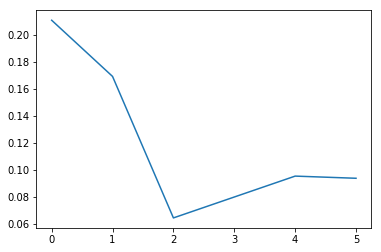

In [33]:
device = pd.DataFrame({'mean_click_by_device_type' : data2.click.groupby(data2['device_type']).mean()}).reset_index()
plt.plot(device.device_type, device.mean_click_by_device_type)
plt.show

### Random Forest

In [ ]:
train.columns

Index(['click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type',
       'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'day_of_week',
       'hour_mean_enc', 'banner_pos_mean_enc', 'site_category_mean_enc',
       'app_category_mean_enc', 'device_type_mean_enc',
       'day_of_week_mean_enc'],
      dtype='object')

In [ ]:
X_train = train[['hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type',
       'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'day_of_week',
       'hour_mean_enc', 'banner_pos_mean_enc', 'site_category_mean_enc',
       'app_category_mean_enc', 'device_type_mean_enc',
       'day_of_week_mean_enc']]
y_train = train['click']

X_val = val[['hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type',
       'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'day_of_week',
       'hour_mean_enc', 'banner_pos_mean_enc', 'site_category_mean_enc',
       'app_category_mean_enc', 'device_type_mean_enc',
       'day_of_week_mean_enc']]
y_val = val['click']

X_test = test[['hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type',
       'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'day_of_week',
       'hour_mean_enc', 'banner_pos_mean_enc', 'site_category_mean_enc',
       'app_category_mean_enc', 'device_type_mean_enc',
       'day_of_week_mean_enc']]
y_test = test['click']

### Parameter Tuning Using Validation Set

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(random_state=42,
                           n_estimators=10,
                           max_depth=5,
                           max_leaf_nodes=5)

In [ ]:
from sklearn.metrics import log_loss

rf1.fit(X_train, y_train)
print('Training loss: ', log_loss(y_train, rf1.predict_proba(X_train)[:,1]))
print('Validation loss: ', log_loss(y_val, rf1.predict_proba(X_val)[:,1]))

Training loss:  0.43751255625550856
Validation loss:  0.43749216709142785


In [ ]:
rf2 = RandomForestClassifier(random_state=42,
                           n_estimators=20,
                           max_depth=5,
                           max_leaf_nodes=5,
                           min_samples_leaf=10)

rf2.fit(X_train, y_train)
print('Training loss: ', log_loss(y_train, rf2.predict_proba(X_train)[:,1]))
print('Validation loss: ', log_loss(y_val, rf2.predict_proba(X_val)[:,1]))

Training loss:  0.436924866572778
Validation loss:  0.4369811509299821


### log loss

In [ ]:
print('Training loss: ', log_loss(y_train, rf2.predict_proba(X_train)[:,1]))
print('Testing loss: ', log_loss(y_test, rf2.predict_proba(X_test)[:,1]))